<a href="https://colab.research.google.com/github/Gamma1024/ML_in_Finance/blob/main/ClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Finance
## Exploratory Data Analysis

In [ ]:
############## Importing Necessary Packages ##############
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold , cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from numpy import isnan
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

In [ ]:
!git clone https://github.com/Gamma1024/ML_in_Finance.git

Cloning into 'ML_in_Finance'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [ ]:
############## Loading The Data ##############
## Loading findata
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
findata_2014 = pd.read_csv("ML_in_Finance/Data/2014_Financial_Data.csv", index_col = 0)
findata_2015 = pd.read_csv("ML_in_Finance/Data/2015_Financial_Data.csv", index_col = 0)
findata_2016 = pd.read_csv("ML_in_Finance/Data/2016_Financial_Data.csv", index_col = 0)
findata_2017 = pd.read_csv("ML_in_Finance/Data/2017_Financial_Data.csv", index_col = 0)
findata_2018 = pd.read_csv("ML_in_Finance/Data/2018_Financial_Data.csv", index_col = 0)
print(findata_2014.shape)
print(findata_2015.shape)
print(findata_2016.shape)
print(findata_2017.shape)
print(findata_2018.shape)
findata_2014._get_numeric_data().columns.shape
is_numeric_dtype(findata_2014["Sector"]) # categorical variable we need to convert later on

(3808, 224)
(4120, 224)
(4797, 224)
(4960, 224)
(4392, 224)


False

The original task on [kaggle](https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018) was to classify the data into buy-worthy and non-buy-worthy stocks. For this task the last column consists of the dummy variable "Class" which indicates whether one should buy or not buy a particular stock in the beginning of the corresponding year. Hence, we need to transform the column "Class" so that it can take the values 0 for **Sell**, 1 for **Hold** and 2 for **Buy**. For this we calculate the excess return over the benchmark i.e. the S&P 500 and classify the stocks based on their excess return into the classes 2/Buy if excess_return > 2.5%, 1/Hold if excess_return $\in$ [-2.5%, 2.5%] and 0/Sell if excess_return < -2.5%. Later on we want to concatenate the dataframes and therefore we change the name of the columns "201x PRICE VAR [%]" to "PRICE VAR [%]" so that the name of the variable is the same for all years.

In [ ]:
############## Change Variable "Class" ##############
## Yearly Means of S&P 500
sp500_means = pd.Series([11.39, -0.73, 9.54, 19.42, -6.24], 
                        index = ["2014", "2015", "2016", "2017", "2018"])
print(sp500_means)

looplist = [[findata_2014, "2015 PRICE VAR [%]", "2014"], [findata_2015, "2016 PRICE VAR [%]", "2015"], [findata_2016, "2017 PRICE VAR [%]", "2016"],
            [findata_2017, "2018 PRICE VAR [%]", "2017"], [findata_2018, "2019 PRICE VAR [%]", "2018"]]
for data, price_var, year in looplist:
   ## Subtracting S&P 500 means to get excess return
   # e.g. findata_2014["excess_return"] = np.subtract(findata_2014["2015 PRICE VAR [%]"], sp500_means[0])
   data["excess_return"] = np.subtract(data[price_var], sp500_means[year])
   ## rename the columns 201x PRICE VAR [%] to PRICE VAR [%] to concatenate
   data.columns = ["PRICE VAR [%]" if x == price_var else x for x in data.columns]
   ## Reassigning Class
   # class 2 if excess_return>2.5, 0 if excess_return < -2.5, else class 1
   data["Class"] = data["excess_return"].apply(lambda x: 2 if x > 2.5 else (0 if x < -2.5 else 1))
   print(data["PRICE VAR [%]"].isna().sum())
# no NA's in the column "PRICE VAR [%]"

print(findata_2014.iloc[::,222:225].head()) # column 223 is "Class", 224 is "excess_return"

2014    11.39
2015    -0.73
2016     9.54
2017    19.42
2018    -6.24
dtype: float64
0
0
0
0
0
      PRICE VAR [%]  Class  excess_return
PG        -9.323276      0     -20.713276
VIPS     -25.512193      0     -36.902193
KR        33.118297      2      21.728297
RAD        2.752291      0      -8.637709
GIS       12.897715      1       1.507715


In [ ]:
# %%timeit
# for data in [findata_2014, findata_2015, findata_2016, findata_2017, findata_2018]:
#    data["Class"] = data["excess_return"].apply(lambda x: 2 if x > 2.5 else (0 if x < -2.5 else 1))

100 loops, best of 5: 11 ms per loop


In [ ]:
############## Concatenating the Data ##############
## Concatenate the Data
frames = [findata_2014, findata_2015, findata_2016, findata_2017,
          findata_2018]
findata = pd.concat(frames)
print(findata.shape)
findata.head(3)
findata.info()
findata.describe()

(22077, 225)
<class 'pandas.core.frame.DataFrame'>
Index: 22077 entries, PG to ZYME
Columns: 225 entries, Revenue to excess_return
dtypes: float64(223), int64(1), object(1)
memory usage: 38.1+ MB


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,PRICE VAR [%],Class,excess_return
count,2.090600e+04,19989.000000,2.030600e+04,2.087000e+04,1.993900e+04,2.040800e+04,2.037500e+04,2.097600e+04,2.035800e+04,2.071300e+04,...,19952.000000,19650.000000,19690.000000,19213.000000,19462.000000,19598.000000,19655.000000,2.207700e+04,22077.000000,2.207700e+04
mean,5.161619e+09,3.622214,3.258565e+09,1.970452e+09,1.033333e+08,8.699279e+08,1.368670e+09,5.896979e+08,9.778939e+07,4.925003e+08,...,10.978239,0.158858,1.134221,0.783208,3.733922,0.295610,0.365149,2.698893e+02,0.930244,2.628663e+02
std,3.197314e+10,312.648170,2.583092e+10,8.735750e+09,7.676062e+08,3.804283e+09,5.662984e+09,2.976454e+09,4.996543e+08,2.484345e+09,...,1101.098165,3.268154,45.381079,66.524006,174.864701,12.974127,15.030054,1.934617e+04,0.973200,1.934614e+04
min,-6.276160e+08,-12.769300,-2.986888e+09,-1.280800e+10,-1.098000e+08,-1.401594e+08,-5.495512e+09,-1.933900e+10,-1.710954e+09,-2.177200e+10,...,-1.000000,-1.000000,-1.000000,-3963.131200,-1.051000,-2.662200,-2.369900,-1.003972e+02,0.000000,-1.194191e+02
25%,5.880737e+07,-0.014700,3.211750e+06,3.035575e+07,0.000000e+00,1.768550e+07,3.564150e+07,-4.433750e+06,0.000000e+00,-8.745000e+06,...,-0.051125,0.000000,-0.031075,-0.103800,-0.067475,0.000000,-0.013700,-1.947409e+01,0.000000,-3.105527e+01
50%,4.352510e+08,0.057600,1.530115e+08,1.943525e+08,0.000000e+00,8.062450e+07,1.564000e+08,3.585350e+07,3.697000e+06,2.380000e+07,...,0.009500,0.000000,0.048000,0.032400,0.000000,0.000000,0.061000,3.909087e+00,0.000000,-3.623521e+00
75%,2.287259e+09,0.182400,1.180224e+09,8.806035e+08,1.220150e+07,3.699722e+08,6.210870e+08,2.554363e+08,4.969325e+07,1.964680e+08,...,0.200550,0.058400,0.176800,0.142100,0.150075,0.000000,0.185350,2.750567e+01,2.000000,2.515604e+01
max,1.886894e+12,42138.663900,1.581527e+12,4.621600e+11,2.883700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,8.720500e+10,...,153332.333300,293.473000,5468.426400,7039.325900,17646.823500,1542.611000,2042.000000,2.418601e+06,2.000000,2.418590e+06


-5.281841982079795
GNL     2.418601e+06
BW      6.955667e+05
NK      1.732000e+05
PUB     1.443588e+05
RUN     7.836667e+04
BKI     6.602000e+04
SUM     4.023329e+04
JP      2.520000e+04
JAX     2.416667e+04
OPNT    1.960000e+04
AMRH    1.310000e+04
PEN     9.864815e+03
PJT     6.799999e+03
FSB     5.843182e+03
YRIV    2.933333e+03
LBCC    2.292857e+03
CC      2.248621e+03
GBT     1.993912e+03
SSNT    1.041667e+03
BSM     1.000607e+03
Name: PRICE VAR [%], dtype: float64
RHE    -100.397220
ARA     -98.333333
FTAI    -98.289550
AAMC    -94.755181
RGSE    -94.272727
GLBS    -93.913044
EIGR    -92.711948
AEZS    -92.533333
TELL    -92.527174
SCON    -92.500000
COE     -92.299086
APEN    -91.929825
RSLS    -91.268447
CPST    -90.540541
SBLK    -90.032680
NXTD    -89.915966
GOL     -89.560440
USEG    -89.333333
YUMA    -89.204545
NSPR    -89.000000
Name: PRICE VAR [%], dtype: float64


(0.0, 0.9)

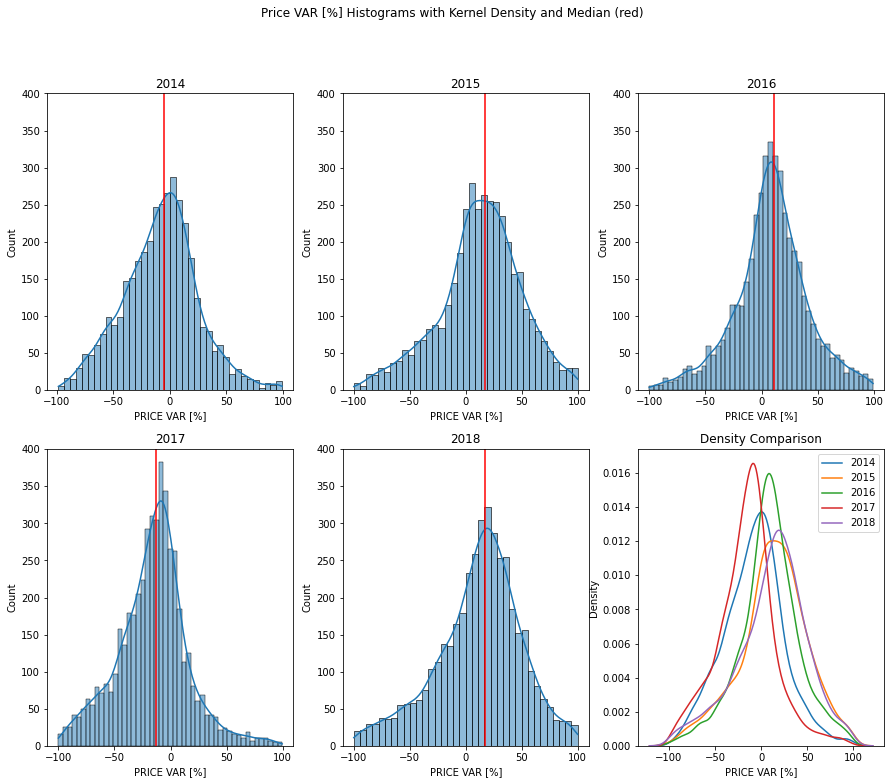

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

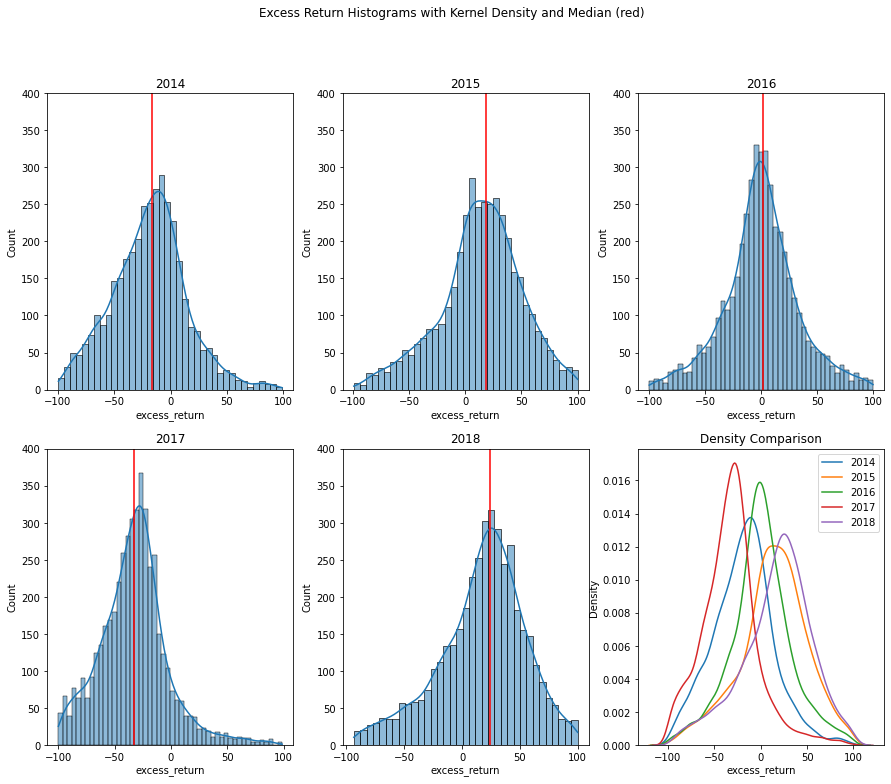

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

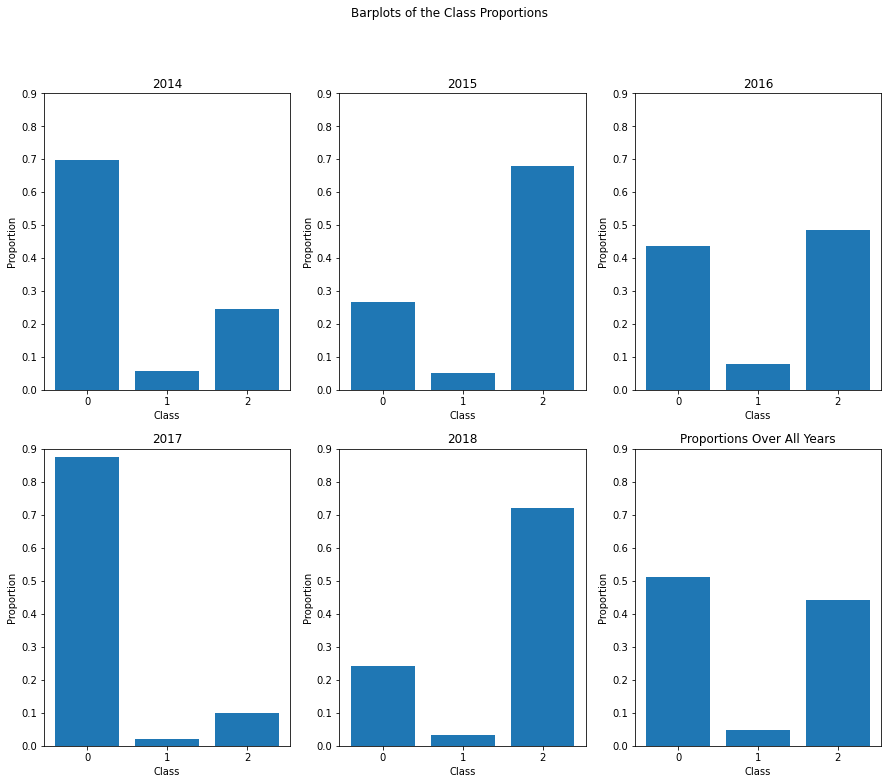

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
############## Further Investigations ##############
print(np.median(findata_2014.iloc[:, 222]))
print(findata_2014.iloc[:, 222].nlargest(n = 20)) 
print(findata_2014.iloc[:, 222].nsmallest(n = 20))
# very extreme returns, thus need to adjust xrange in plots to not get range from min to max observation
plotloop = [[findata_2014, "2014", 0], [findata_2015, "2015", 1], [findata_2016, "2016", 2], [findata_2017, "2017", 3], [findata_2018, "2018", 4]]

## Plot Histogram of Price VAR [%] for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) # create plot matrix with 2 rows and 3 columns
fig.suptitle("Price VAR [%] Histograms with Kernel Density and Median (red)")
ax = ax.ravel() # flatten the axis array
for data, year, k in plotloop:
  data_hist = data.iloc[:, 222][data.iloc[:, 222].between(-100, 100)]
  # only consider returns between -100% and 100% so that histogram is not influenced by very extreme values
  ax[k].set_title(year)
  plt.figure()
  sns.histplot(data_hist, kde = True, ax = ax[k])
  ax[k].set_ylim(0, 400)
  ax[k].axvline(x=np.median(data.iloc[:, 222]), color="red") # vertical line with median of the column PRICE VAR [%] of year 201x
  # Plot density of all years together to compare them
  sns.kdeplot(data_hist, label = year, ax = ax[5])
ax[5].legend()
ax[5].set_title("Density Comparison")

## Plot Histogram of excess_return for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) 
fig.suptitle("Excess Return Histograms with Kernel Density and Median (red)")
ax = ax.ravel()
for data, year, k in plotloop:
  data_hist = data.iloc[:, 224][data.iloc[:, 224].between(-100, 100)]
  # only consider returns between -100% and 100% so that histogram is not influenced by very extreme values
  ax[k].set_title(year)
  plt.figure()
  sns.histplot(data_hist, kde = True, ax = ax[k])
  ax[k].set_ylim(0, 400)
  ax[k].axvline(x=np.median(data.iloc[:, 224]), color="red") # vertical line with median of the column excess_return of year 201x
  # Plot density of all years together to compare them
  sns.kdeplot(data_hist, label = year, ax = ax[5])
ax[5].legend()
ax[5].set_title("Density Comparison")

## Plot Barplot of proportion of Class for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) 
fig.suptitle("Barplots of the Class Proportions")
ax = ax.ravel()
y_pos = np.arange(3)
for data, year, k in plotloop:
  ax[k].set_title(year)
  plt.figure()
  ax[k].set_xlabel("Class") # set common x label
  ax[k].set_ylabel("Proportion") # set common y label
  height = [sum(data["Class"] ==0)/data.shape[0], sum(data["Class"] ==1)/data.shape[0], sum(data["Class"] ==2)/data.shape[0]]
  ax[k].bar(y_pos, height)
  ax[k].set_xticks([0, 1, 2]) 
  ax[k].set_xticklabels([0, 1, 2])
  ax[k].set_ylim(0, 0.9)
sell_prop  = sum(findata["Class"] == 0)/findata.shape[0]
hold_prop = sum(findata["Class"] == 1)/findata.shape[0]
buy_prop = sum(findata["Class"] ==2)/findata.shape[0]
height = [sell_prop, hold_prop, buy_prop]
ax[5].bar(y_pos, height)
ax[5].set_xticks([0, 1, 2]) 
ax[5].set_xticklabels([0, 1, 2])
ax[5].set_xlabel("Class")
ax[5].set_ylabel("Proportion")
ax[5].set_title("Proportions Over All Years")
ax[5].set_ylim(0, 0.9)

PG             NaN
VIPS           NaN
KR             NaN
RAD     33998000.0
GIS            NaN
Name: Preferred Dividends, dtype: float64

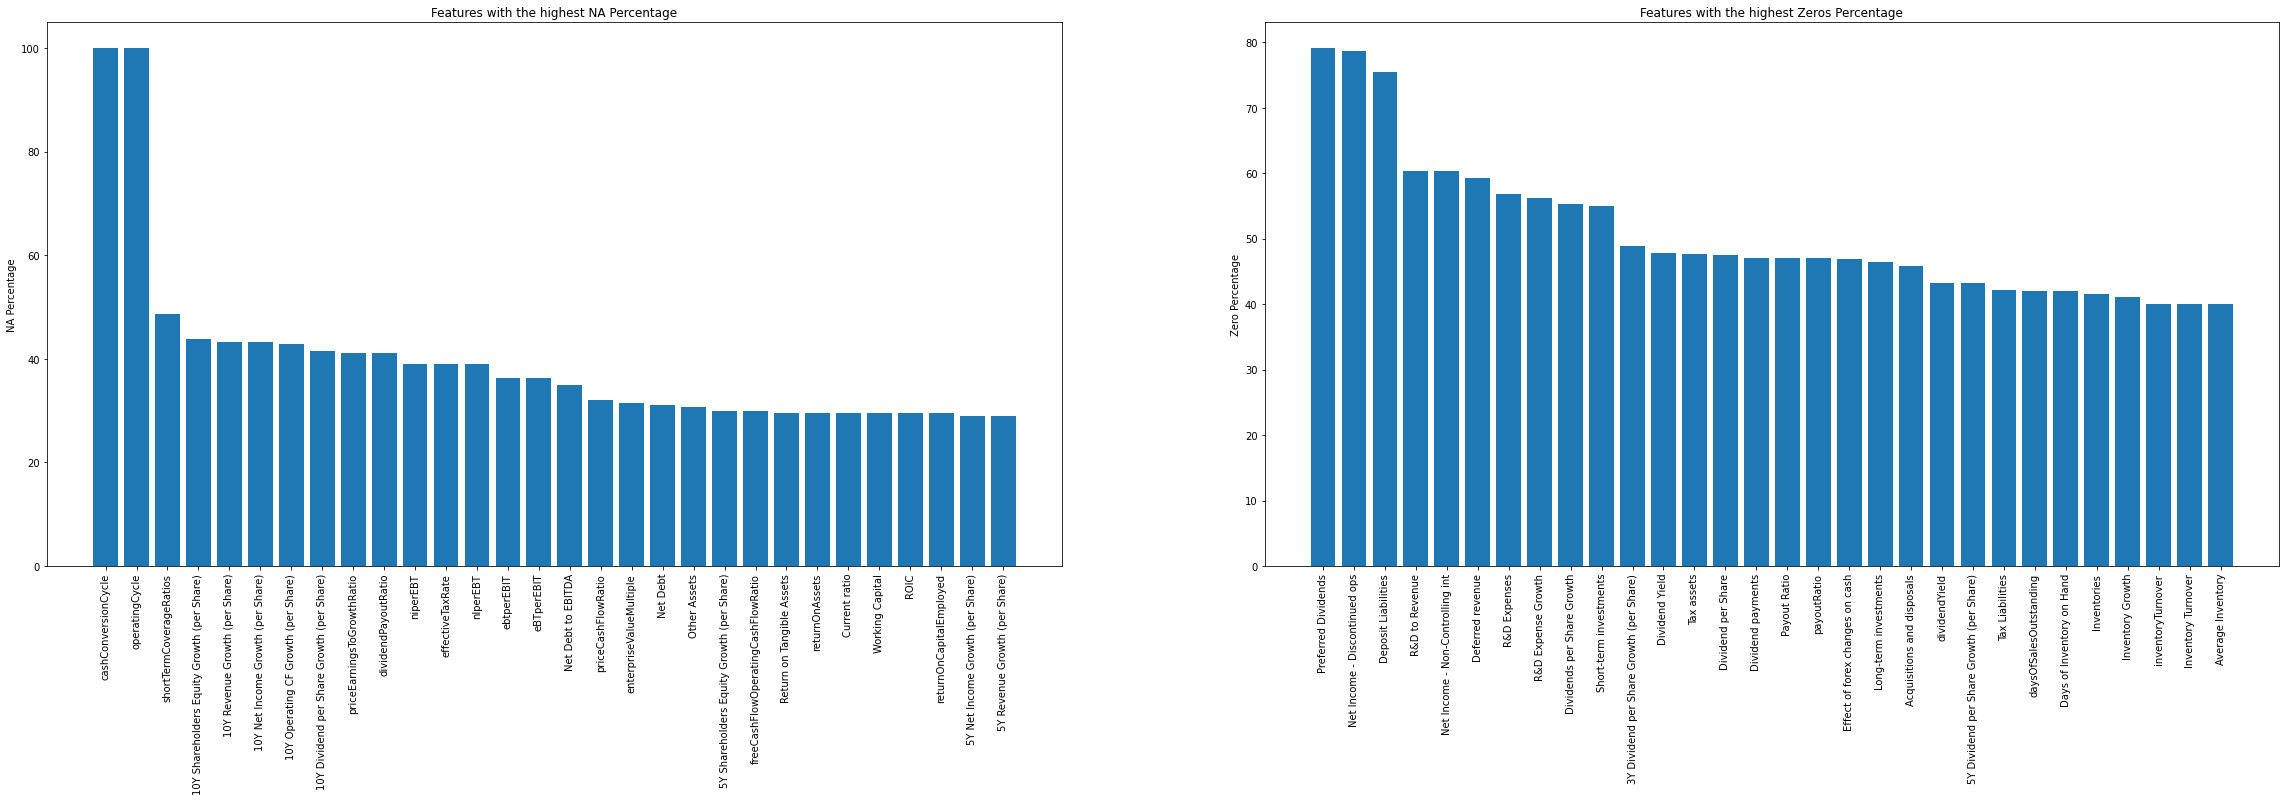

In [ ]:
############## Nas and Zeros in the Dataset ##############
## Calculating the Percentage of NAs/Zeros
# Percentage of NAs:
na_percent = (findata.isna().sum()/findata.shape[0]*100).sort_values(ascending = False)
# Percentage of Zeros of all columns but response Class:
zero_percent = (findata.loc[:, findata.columns != "Class"].isin([0]).sum()/findata.shape[0]*100).sort_values(ascending = False)

## Plotting the Results
fig, ax = plt.subplots(nrows = 1, ncols = 2 , figsize=(40, 10))
ax = ax.ravel()

na_labels = na_percent[0:30].index.values.tolist()
ax[0].bar(np.arange(30), na_percent[0:30].values.tolist())
ax[0].set_xticks(np.arange(30))
ax[0].set_ylabel("NA Percentage")
ax[0].set_xticklabels(na_labels, rotation=90)
ax[0].set_title("Features with the highest NA Percentage")

zero_labels =  zero_percent[0:30].index.values.tolist()
ax[1].bar(np.arange(30), zero_percent[0:30].values.tolist())
ax[1].set_xticks(np.arange(30))
ax[1].set_ylabel("Zero Percentage")
ax[1].set_xticklabels(zero_labels, rotation=90)
ax[1].set_title("Features with the highest Zeros Percentage")

## Convert 0s to NAs
findata.iloc[:,0:222] = findata.iloc[::,0:222].replace({"0" : np.nan, 0 : np.nan})
findata["Preferred Dividends"].head(5) # making sure it has worked

While analyzing the data, we realized that NA's and the value 0 are used interchangeably. To make the data uniform, we decided to convert the 0's into NA's. For 3 columns, however, the 0's could actually represent the true values. These columns are "Tax Liabilities", "Preferred Dividends" and "Goodwill and intangible assets". However, because a high proportion of these columns have the value 0, these features are not informative either way and we decided to drop them. As a consequence, we decided to convert the 0's in all columns to NA's.

In [ ]:
############## Remove Identical Columns ##############
na_sum = findata.isna().sum()
na_sum_series = na_sum.squeeze() # convert data frame to pandas series
print(na_sum_series.sort_values(ascending = False).head(10)) # sort values in descending order

identical_columns = [] # create empty list to store identicao columns
for i in range(findata.shape[1]):
  for j in range(i+1, findata.shape[1]):
    if findata.iloc[:, i].equals(findata.iloc[:, j])==1: # pairwise compare columns whether they are identical or not
      identical_columns.append([findata.columns[i], findata.columns[j]]) # append identical columns to list identical_columns
for column1, column2 in identical_columns:
  findata.drop(column1, axis = 1, inplace = True) # drop one of the two columns that are identical
print(identical_columns)
findata.shape # 11 columns identical

cashConversionCycle                          22058
operatingCycle                               22058
Preferred Dividends                          19717
Net Income - Discontinued ops                19620
Deposit Liabilities                          18935
10Y Dividend per Share Growth (per Share)    16089
R&D to Revenue                               15585
Net Income - Non-Controlling int             15567
5Y Dividend per Share Growth (per Share)     15308
Deferred revenue                             15086
dtype: int64
[['ebitperRevenue', 'eBITperRevenue'], ['ebtperEBIT', 'eBTperEBIT'], ['niperEBT', 'nIperEBT'], ['returnOnAssets', 'Return on Tangible Assets'], ['returnOnCapitalEmployed', 'ROIC'], ['payablesTurnover', 'Payables Turnover'], ['inventoryTurnover', 'Inventory Turnover'], ['daysOfSalesOutstanding', 'Days of Inventory on Hand'], ['debtRatio', 'Debt to Assets'], ['debtEquityRatio', 'Debt to Equity'], ['cashFlowToDebtRatio', 'cashFlowCoverageRatios']]


(22077, 214)

0.1-->182 observations left out

In [ ]:
############## NA Threshold ##############
na_threshold = 0.3 # threshold for NA percentage
print(sum(findata.isna().mean() > na_threshold)) # 75 of the remaining variables have more than 30% NAs
findata = findata.loc[::, findata.isna().mean() < na_threshold] # drop all columns with NA proportion higher than threshold
findata[["Class", "Sector"]].dtypes
findata.shape

75


(22077, 139)

In [ ]:
############## Train-Test Split ##############
## Convert Sector& Class to Factors
findata = pd.concat([findata, pd.get_dummies(findata['Sector'], prefix='Sector')],axis=1).drop(['Sector'],axis=1) # replace 
label_encoder  = pp.LabelEncoder()
findata["Class"] = label_encoder.fit_transform(findata["Class"])
pd.factorize(findata["Class"])
print(findata.iloc[:,-15:].head(3))
print(findata.shape)
X = findata.drop(["Class", "excess_return", "PRICE VAR [%]"], axis = 1) # all columns but response Class and the variables we needed to classify the stocks
y = findata['Class']
print(y.value_counts()) # Upsampling required (but only after train-test split)

## Train-Test Split
# To impute the missing values we need to first split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42) # Train-Test Split 90:10 according to Script/ Raschka (2015)
# Print proportions of each class in the train set
print(f"Sell proportion:  {sum(y_train ==0)/X_train.shape[0]: .6f}")
print(f"Hold proportion:  {sum(y_train ==1)/X_train.shape[0]: .6f}")
print(f"Buy proportion: {sum(y_train ==2)/X_train.shape[0]: .6f}")


      SG&A Expenses Growth  PRICE VAR [%]  Class  excess_return  \
PG                 -0.1746      -9.323276      0     -20.713276   
VIPS                1.7313     -25.512193      0     -36.902193   
KR                  0.0234      33.118297      2      21.728297   

      Sector_Basic Materials  Sector_Communication Services  \
PG                         0                              0   
VIPS                       0                              0   
KR                         0                              0   

      Sector_Consumer Cyclical  Sector_Consumer Defensive  Sector_Energy  \
PG                           0                          1              0   
VIPS                         0                          1              0   
KR                           0                          1              0   

      Sector_Financial Services  Sector_Healthcare  Sector_Industrials  \
PG                            0                  0                   0   
VIPS                     

Now it is time to fill the missing values using the KNN imputer. The following code block may take some minutes to execute.

In [ ]:
############## Imputation ##############
# First use X_train to fit the imputer, then apply it to X_train and X_test
# Important: We DO NOT use X_test to fit the imputer seperately
imputer = KNNImputer(n_neighbors = 5, weights = "uniform") # n_jobs = -1 to use all CPU cores
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
print("NAs remaining: ", sum(isnan(X_train).flatten()))
print("NAs remaining: ", sum(isnan(X_test).flatten()))

NAs remaining:  0
NAs remaining:  0


We have learnt in the lecture that decision tree algorithms are insensitive to the data's magnitude unlike other algorithms like e.g. PCA or SVM. Consequently, there exists a decision tree algorithm called Isolation Forest that can detect anomalies/ outliers in the data. Below we make use of this algorithm:

In [ ]:
############## Outlier Detection ##############
outliers = IsolationForest(random_state = 42).fit(X_train) # fit Isolation Forest to training data
outliers_train = outliers.predict(X_train)
outliers_test = outliers.predict(X_test)
# Remove outliers where 1 represent inliers and -1 represent outliers:
X_train_cleaned = X_train[np.where(outliers_train == 1, True, False)]
y_train_cleaned = y_train[np.where(outliers_train == 1, True, False)]
X_test_cleaned = X_test[np.where(outliers_test == 1, True, False)]
y_test_cleaned = y_test[np.where(outliers_test == 1, True, False)]
print("Shape with outliers: ", X_train.shape,", Shape without outliers: ", X_train_cleaned.shape,", Removed outliers: ", X_train.shape[0]-X_train_cleaned.shape[0])
print("Shape with outliers: ", X_test.shape,", Shape without outliers: ", X_test_cleaned.shape,", Removed outliers: ", X_test.shape[0]-X_test_cleaned.shape[0]) 
# Print proportions of each class in cleaned data set
sell_prop_trainc = sum(y_train_cleaned == 0)/X_train_cleaned.shape[0]
hold_prop_trainc = sum(y_train_cleaned == 1)/X_train_cleaned.shape[0]
buy_prop_trainc = sum(y_train_cleaned == 2)/X_train_cleaned.shape[0]
print(f"Sell proportion:  {sell_prop_trainc: .6f}")
print(f"Hold proportion:  {hold_prop_trainc: .6f}")
print(f"Buy proportion:  {buy_prop_trainc: .6f}")

Shape with outliers:  (19869, 146) , Shape without outliers:  (19648, 146) , Removed outliers:  221
Shape with outliers:  (2208, 146) , Shape without outliers:  (2188, 146) , Removed outliers:  20
Sell proportion:   0.509976
Hold proportion:   0.046977
Buy proportion:   0.443048


Contrary to upsampling using the resample() function, the SMOTE() (Synthetic Minority Oversampling TEchnique) function creates new, additional observations that increase the variation within the data and thus provides additional information to the model. We use SMOTE() in a pipeline so that the k-fold cross validation train scores are closer to test scores. It is important to note that the pipeline implementation does not work using the sklearn pipeline but one has to use the imb pipeline instead. The biggest problem with using SMOTE() is that the newly created samples of the categorical variables are numerical and not categorical. To make sure categorical variables stay categorical there would exist the SMOTENC() function that requires the categorical variables to not be one-hot-encoded. Since we had to one-hot-encode the Sector variable to apply the KNN imputer we use the SMOTE() function and not the SMOTENC() function.

In [ ]:
############## Upsampling ##############
######### Also try Resampling using Resample()
# smote= SMOTE(random_state = 42)
# # Upsampling is done only in the training set!!!
# X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train_cleaned, y_train_cleaned)
# # We use _upsampled only for models without hyperparameters to tune
# # Otherwise the upsampling is implemented in the pipeline
# print(y_train_upsampled.value_counts()) # all classes have equally many observations
# y_train_upsampled
# X_train_upsampled[:, -1]
# for i in np.arange(1, 12, 1):
#   print(sum((X_train_upsampled[:, -i]!=0)&(X_train_upsampled[:, -i]!=1)))
#   X_train_upsampled[:,-i] = np.round(X_train_upsampled[:,-i])
# print(sum((X_train_upsampled[:, -1]!=0)&(X_train_upsampled[:, -1]!=1)))
# print(sum((y_train_upsampled!=0)&(y_train_upsampled!=1)&(y_train_upsampled!=2)))

In [ ]:
############## Upsampling ##############
# X_train_hold = X_train_cleaned[y_train_cleaned==1]
# X_train_buy = X_train_cleaned[y_train_cleaned==2]
# X_train_sell = X_train_cleaned[y_train_cleaned==0]
# y_train_sell = y_train_cleaned[y_train_cleaned==0]
# ### Now, downsamples majority labels equal to the number of samples in the minority class

# X_train_hold_upsampled, y_train_hold_upsampled = resample(X_train_hold, y_train_cleaned[y_train_cleaned==1], replace = True, 
#                                                           n_samples = X_train_sell.shape[0], random_state = 42)
# X_train_buy_upsampled, y_train_buy_upsampled = resample(X_train_buy, y_train_cleaned[y_train_cleaned==2], replace = True, 
#                                                           n_samples = X_train_sell.shape[0], random_state = 42)

# ### concat the majority and minority dataframes
# X_train_upsampled = pd.concat([pd.DataFrame(X_train_hold_upsampled), pd.DataFrame(X_train_buy_upsampled),pd.DataFrame(X_train_sell)])
# y_train_upsampled = pd.concat([pd.DataFrame(y_train_hold_upsampled), pd.DataFrame(y_train_buy_upsampled),pd.DataFrame(y_train_sell)])



# ## Shuffle the dataset to prevent the model from getting biased by similar samples
# X_train_upsampled = X_train_upsampled.sample(frac=1, random_state= 42)
# y_train_upsampled = y_train_upsampled.sample(frac=1, random_state= 42)
ros = RandomOverSampler(random_state = 42)
X_train_upsampled, y_train_upsampled = ros.fit_resample(X_train_cleaned, y_train_cleaned)
print(y_train_upsampled.value_counts())
for i in np.arange(1, 12, 1):
  print(sum((X_train_upsampled[:, -i]!=0)&(X_train_upsampled[:, -i]!=1)))
  X_train_upsampled[:,-i] = np.round(X_train_upsampled[:,-i])
print(sum((X_train_upsampled[:, -1]!=0)&(X_train_upsampled[:, -1]!=1)))
print(sum((y_train_upsampled!=0)&(y_train_upsampled!=1)&(y_train_upsampled!=2)))

0    10020
2    10020
1    10020
Name: Class, dtype: int64
0
0
0
0
0
0
0
0
0
0
0
0
0


Text(0.5, 1.0, 'Correlation Heatmap')

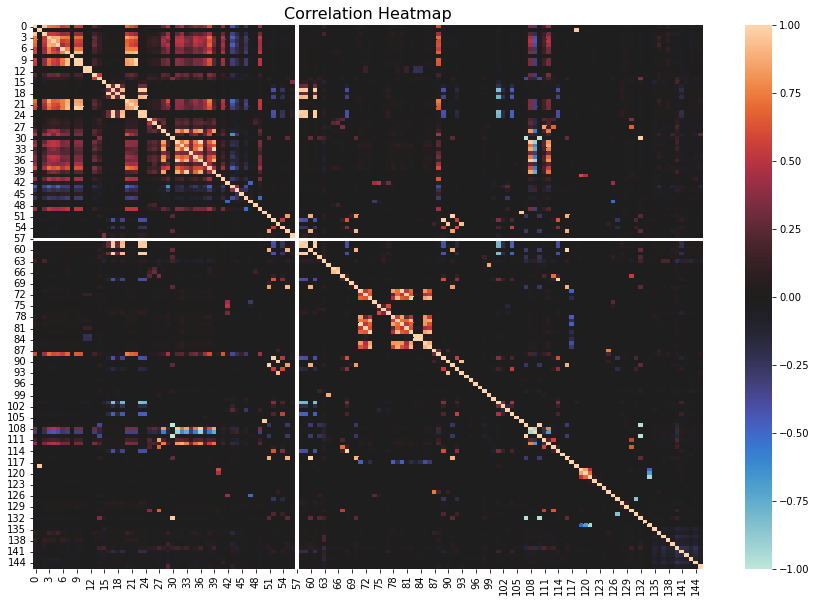

In [ ]:
############## Correlation Matrix##############
corr = pd.DataFrame(X_train_cleaned).corr()
plt.figure(figsize=(15,10)) 
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, center = 0) # heatmap of correlation
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize":16})

We can see that few of the features are highly correlated but many are only barely correlated. Thus, there might be some problems with (linear) PCA since we have many variables that are hardly correlated. Note that correlation only measures the **linear** relationship between the variables and the variables might be dependent in a non-linear way like it is the case with e.g. ratios.  Hence, a non linear dimension reduction approach like e.g. Sigmoid Kernel PCA might yield better results.

In [ ]:
############## Summary Statistics ##############
## k-fold Cross Validation
kFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
# 5 splits since findata is a large dataset (see script)
## Standardizing
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train_upsampled)
X_test_std = sc.fit_transform(X_test_cleaned)

 1 Earnings Yield 0.0106
 2 SG&A to Revenue 0.0105
 3 Book Value per Share Growth 0.0100
 4 Free Cash Flow growth 0.0099
 5 Asset Growth 0.0099
 6 Operating Cash Flow growth 0.0097
 7 Weighted Average Shares Growth 0.0094
 8 EV to Operating cash flow 0.0094
 9 Debt Growth 0.0094
10 Gross Profit Growth 0.0093
11 EV to Free cash flow 0.0093
12 Revenue Growth 0.0093
13 Weighted Average Shares Diluted Growth 0.0092
14 Receivables growth 0.0091
15 Issuance (buybacks) of shares 0.0091
16 SG&A Expenses Growth 0.0091
17 PB ratio 0.0089
18 Income Tax Expense 0.0088
19 Net cash flow / Change in cash 0.0088
20 Operating Income Growth 0.0088
21 priceBookValueRatio 0.0086
22 3Y Revenue Growth (per Share) 0.0085
23 3Y Shareholders Equity Growth (per Share) 0.0085
24 Capex to Depreciation 0.0085
25 EPS Diluted Growth 0.0084
26 Net Income Growth 0.0084
27 ROE     0.0083
28 Issuance (repayment) of debt 0.0083
29 Weighted Average Shs Out (Dil) 0.0082
30 returnOnEquity 0.0082
31 Net Profit Margin 0.0082


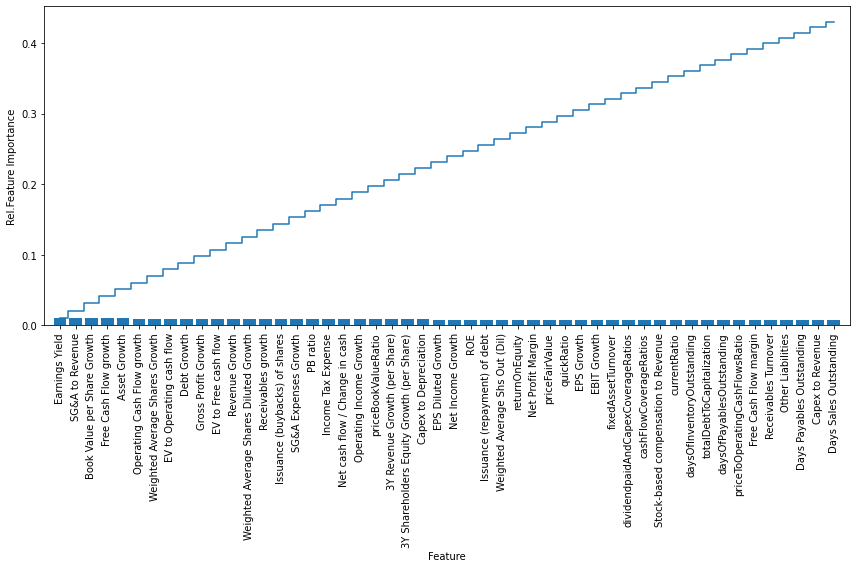

In [67]:
#########################Feartue Seletion##################
feat_labels = findata.columns [:-1]      #columns [:-1]
forest = RandomForestClassifier(random_state = 42)
forest . fit (X_train_cleaned , y_train_cleaned )
importances = forest.feature_importances_
indices = np . argsort ( importances )[:: -1]
n = 50
for i in range ( n ):
  print('{0:2d} {1:7s} {2:6.4f}'.format(i+1,feat_labels[indices[i]],importances[indices[i]]))

feat_imp = np.sort(importances)[::-1]
sum_feat_imp = np.cumsum(feat_imp)[:n]

plt.figure(figsize =(12, 8))
plt.bar(range(n),importances[indices[:n]],align = "center")
plt.xticks (range(n),feat_labels[indices[:n]],rotation =90)
plt.xlim ([-1,n])
plt.xlabel("Feature")
plt.ylabel("Rel.Feature Importance")
plt.step(range(n),sum_feat_imp,where="mid", label = "Cumulative importance")
plt.tight_layout();

## Model Fitting

### Performance Metric
For scoring our models we will be using the weighted $F_1$-Score.

### Naive Classification/ Baseline

              precision    recall  f1-score   support

           0       0.49      0.48      0.49      1131
           1       0.12      0.10      0.11       126
           2       0.41      0.43      0.42       931

    accuracy                           0.44      2188
   macro avg       0.34      0.34      0.34      2188
weighted avg       0.44      0.44      0.44      2188



[Text(69.0, 0.5, 'True Class'),
 Text(0.5, 24.0, 'Assigned Class'),
 Text(0.5, 1.0, 'Confusion Matrix')]

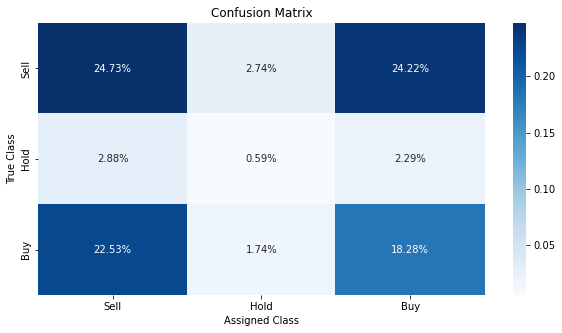

In [ ]:
############## Naive Classification/ Baseline ##############
priors = [sell_prop_trainc, hold_prop_trainc, buy_prop_trainc]
np.random.seed(42) # set seed
# randomly choose classes 0, 1, 2 with probabilities based on proportions from X_train_cleaned
y_pred = np.random.choice([0, 1, 2], size = len(y_test_cleaned), replace = True, p = priors) 


class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")


### Logistic Regression

In [ ]:
############## Logistic Regression ##############
ros = RandomOverSampler(random_state = 42)
scaler = StandardScaler()
pca = PCA()
##### Try l1/ l2 penalty for feature selection
################### 1 model without upsampling

### (Gaussian) Naive Bayes Classifier
Fun fact: LDA is a special case of a naive Bayes classifier.

In [ ]:
############## All Features ##############
gnb = GaussianNB()

pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["gnb", gnb]])
param_grid= {
    "gnb__priors": [None, priors], # priors are either None or proportion of classes in train set calculated above
    "gnb__var_smoothing": np.logspace(0, -10, num = 100),
}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

std_best_score = gs.cv_results_["std_test_score"][gs.best_index_]

print(f"Best parameters: {gs.best_params_}")
print(f"Mean CV score: {gs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(gs.score(X_test_cleaned, y_test_cleaned)))


y_pred = gs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

In [ ]:
############## Random Forest Feature Selection ##############
forest = RandomForestClassifier(random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = forest, threshold = "median")],
                          ["ros", ros], ["gnb", gnb]])

param_grid= {
    "gnb__priors": [None, priors], 
    "gnb__var_smoothing": np.logspace(0, -10, num = 10),
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

std_best_score = gs.cv_results_["std_test_score"][gs.best_index_]

print(f"Best parameters: {gs.best_params_}")
print(f"Mean CV score: {gs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(gs.score(X_test_cleaned, y_test_cleaned)))


y_pred = gs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters: {'kpca__n_components': 7, 'kpca__kernel': 'rbf', 'gnb__var_smoothing': 0.007564633275546291, 'gnb__priors': [0.5099755700325733, 0.046976791530944625, 0.4430476384364821]}
Mean CV score:  0.488469
Standard deviation of CV score:  0.004355
Test Score: 0.48
              precision    recall  f1-score   support

           0       0.54      0.73      0.62      1131
           1       0.00      0.00      0.00       126
           2       0.47      0.33      0.39       931

    accuracy                           0.52      2188
   macro avg       0.34      0.35      0.33      2188
weighted avg       0.48      0.52      0.48      2188



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(69.0, 0.5, 'True Class'),
 Text(0.5, 24.0, 'Assigned Class'),
 Text(0.5, 1.0, 'Confusion Matrix')]

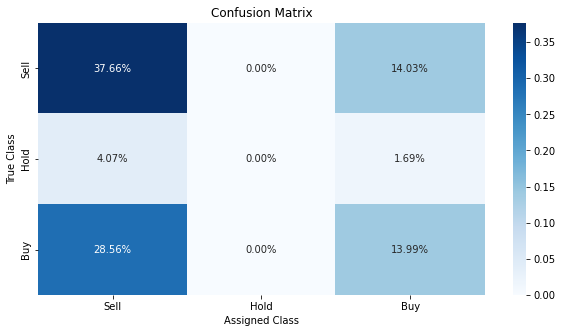

In [ ]:
############## Kernel PCA ##############
gnb = GaussianNB()
kpca = KernelPCA(random_state = 42, eigen_solver = "arpack", n_jobs = -1)
# if n_components is much less than the number of training samples, randomized (or arpack to a smaller extend) may be more efficient than the dense eigensolver
# We used arpack since randomized matrix to be positive (semi-)definite
pipe = imbpipeline(steps=[["scaler", scaler], ["kpca", kpca], ["ros", ros], ["gnb", gnb]])
random_grid = {
    "gnb__priors": [None, priors], 
    "gnb__var_smoothing": np.logspace(0, -10, num = 100),
    "kpca__n_components": np.arange(4, 10, 1),
    "kpca__kernel": ["linear", "poly" , "rbf", "sigmoid"] #linear is the "normal" PCA we have discussed in the lecture
}

# n_jobs = -1,

#gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)

gs = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, scoring = "f1_weighted", n_iter = 30,
                      cv = kFold, random_state = 42,  error_score='raise', n_jobs = -1)

gs = gs.fit(X_train_cleaned, y_train_cleaned)

std_best_score = gs.cv_results_["std_test_score"][gs.best_index_]

print(f"Best parameters: {gs.best_params_}")
print(f"Mean CV score: {gs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(gs.score(X_test_cleaned, y_test_cleaned)))

y_pred = gs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

In [ ]:
############## Kernel PCA Finetuning ##############
kpca_gnb_ft = KernelPCA(random_state = 42, kernel = "sigmoid", n_components = 8, eigen_solver = "arpack", n_jobs = -1)
gnb_ft = GaussianNB(priors = priors, var_smoothing = 0.007564633275546291)
pipe = imbpipeline(steps=[["scaler", scaler], ["kpca", kpca_gnb_ft], ["ros", ros], ["gnb", gnb_ft]])

param_grid = {
    "kpca__gamma": np.linspace(0.005, 0.01, 10),
    "kpca__coef0": np.linspace(0.8, 1.2, 6)
}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

std_best_score = gs.cv_results_["std_test_score"][gs.best_index_]

print(f"Best parameters: {gs.best_params_}")
print(f"Mean CV score: {gs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(gs.score(X_test_cleaned, y_test_cleaned)))

y_pred = gs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

### Random Forest

In [ ]:
forest = RandomForestClassifier(random_state = 42)
rfpipe = imbpipeline(steps=[["ros", ros], ["rf", forest]])

random_grid = {
    "rf__bootstrap": [True, False],
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 2, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([2, 5, 10, 30, 50]),
    "rf__min_samples_split": np.array([2, 5, 10, 20]),
    "rf__n_estimators": np.array([10, 50, 100, 200, 500]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 10, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)
std_best_score = rs.cv_results_["std_test_score"][rs.best_index_]

print(f"Best parameters: {rs.best_params_}")
print(f"Mean CV score: {rs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(rs.score(X_test_cleaned, y_test_cleaned)))

y_pred = rs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

In [ ]:
############## Broad Hyperparametertuning ##############
forest = RandomForestClassifier(random_state = 42)
print(forest.get_params().keys())
kpca = KernelPCA(random_state = 42)
#kpca = KernelPCA(random_state = 42, kernel = "sigmoid", n_components = 8)
rfpipe = imbpipeline(steps=[["scaler", scaler],["kpca", kpca], ["ros", ros], ["rf", forest]])

random_grid = {
    "kpca__n_components": np.arange(4, 10, 1),
    "kpca__kernel": ["linear", "poly" , "rbf", "sigmoid"],
    "rf__bootstrap": [True, False],
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 2, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([2, 5, 10, 30, 50]),
    "rf__min_samples_split": np.array([2, 5, 10, 20]),
    "rf__n_estimators": np.array([10, 50, 100, 200, 500]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 20, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)
std_best_score = rs.cv_results_["std_test_score"][rs.best_index_]

print(f"Best parameters: {rs.best_params_}")
print(f"Mean CV score: {rs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(rs.score(X_test_cleaned, y_test_cleaned)))

y_pred = rs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

In [ ]:
############## Hyperparameter Finetuning ##############
forest_ft = RandomForestClassifier(random_state = 42, bootstrap = True, class_weight = "balanced", criterion = "entropy", 
                                   max_features = "sqrt", min_samples_leaf=5)
kpca_rf_ft = KernelPCA(random_state = 42, kernel = "sigmoid", n_components = 6)
rfpipe = imbpipeline(steps=[["kpca", kpca_rf_ft], ["ros", ros], ["rf", forest_ft]])

param_grid = {
    "rf__max_depth": np.array([15, 20, 25, 30]),
    "rf__min_samples_split": np.array([15, 20, 25, 30]),
    "rf__n_estimators": np.array([150, 200, 250, 300]),
}

gs = GridSearchCV(estimator = rfpipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)


std_best_score = gs.cv_results_["std_test_score"][rs.best_index_]

print(f"Best parameters: {gs.best_params_}")
print(f"Mean CV score: {gs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(gs.score(X_test_cleaned, y_test_cleaned)))

y_pred = rs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred, normalize = "all")
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

### Gradient Boosting

In [ ]:
############## Gradient Boosting ##############
xgbc= xgb.XGBClassifier()
xgbc_pipe = imbpipeline([
    ["standard_scaler", scaler],
    ["ros", ros],
    ["xgbc", xgbc],
])

# ["pca", pca],     ["ros", ros],

random_grid = {
    #'pca__n_components': [5, 10, 15, 20],
    "xgbc__max_depth": [2,5, 10, 30],
    "xgbc__n_estimators": [10, 100, 200, 500],
}

# gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
#                   cv = kFold, n_jobs = -1)
# gs = gs.fit(X_train_cleaned, y_train_cleaned)

rs = RandomizedSearchCV(estimator = xgbc_pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 10, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)
std_best_score = rs.cv_results_["std_test_score"][rs.best_index_]

print(f"Best parameters: {rs.best_params_}")
print(f"Mean CV score: {rs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(rs.score(X_test_cleaned, y_test_cleaned)))

y_pred = rs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred)
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm/np.sum(cm), annot = True, fmt = ".2%").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

### Support Vector Machine

In [ ]:
############## Support Vector Machine ##############
svm = SVC(random_state = 42)
svm_pipe = imbpipeline(steps=[["scaler", scaler], ["pca", pca], ["ros", ros], ["SVM", svm]])
random_grid = {
    "pca__n_components": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20],
    "SVM__kernel": ["linear", "poly", "rbf", "sigmoid"]
}
# gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted",
                  #cv = kFold,n_jobs = -1)

rs = RandomizedSearchCV(estimator = svm_pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 10, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)
# gs = gs.fit(X_train_cleaned, y_train_cleaned)

print(svm.get_params().keys())

std_best_score = rs.cv_results_["std_test_score"][rs.best_index_]

print(f"Best parameters: {rs.best_params_}")
print(f"Mean CV score: {rs.best_score_: .6f}")
print(f"Standard deviation of CV score: {std_best_score: .6f}")
print("Test Score: {:.2f}".format(rs.score(X_test_cleaned, y_test_cleaned)))

y_pred = rs.best_estimator_.predict(X_test_cleaned)
class_report = metrics.classification_report(y_test_cleaned, y_pred)
print(class_report)
cm = confusion_matrix(y_test_cleaned, y_pred)
cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = ".2f").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

### Neural Network

In [56]:
############## Neural Network ##############
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable

## Standardise cleaned train& test set
X_train_std = sc.fit_transform(X_train_cleaned)
X_test_std = sc.fit_transform(X_test_cleaned)


X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_std, y_train_cleaned, shuffle = True,
                                                                  test_size = 0.2, random_state = 42) 
# train_ds = [X_train_nn, y_train_nn]
# val_ds = [X_val_nn, y_val_nn]
# test_ds = [X_test_std, y_test_cleaned]

#print(len(train_ds), len(val_ds), len(test_ds))
## Convert Test and Train Set to Tensors
X_train_nn = torch.from_numpy(X_train_nn).type(torch.Tensor)
X_val_nn = torch.from_numpy(X_val_nn).type(torch.Tensor)
X_test_nn = torch.from_numpy(X_test_std).type(torch.Tensor)
y_train_nn = Variable(torch.Tensor(y_train_nn).long())
y_val_nn = Variable(torch.Tensor(y_val_nn).long())
y_test_nn = Variable(torch.Tensor(y_test_cleaned).long())
print(X_train_nn.size(), y_train_nn.size())
print(X_val_nn.size(), y_val_nn.size())
print(X_test_nn.size(), y_test_nn.size())

# Check whether GPU is available
print(torch.cuda.is_available())


## Create the model
class FinModel(nn.Module):
  """Feedforward neural network with 2 hidden layers"""
  def __init__(self, input_size, output_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(input_size, 100)
    # 2nd hidden layer
    self.linear2 = nn.Linear(100, 32)
    # output layer
    self.linear3 = nn.Linear(32, output_size)
    # Dropout Layer to prevent Co-daptation/ high correlation between layers
    self.drop = nn.Dropout(p = 0.2)
  def forward(self, x):
    # Get intermediate outputs using hidden layer
    out = self.linear1(x)
    # Apply activation function relu to introduce non-linearity
    out = F.relu(out)
    # randomly zero some elements of input tensor
    out = self.drop(out)
    out = F.relu(self.linear2(out))
    out = self.drop(out)
    # Get predictions using output layer
    out = F.softmax(self.linear3(out))
    return out

torch.Size([15720, 146]) torch.Size([15720])
torch.Size([3931, 146]) torch.Size([3931])
torch.Size([2188, 146]) torch.Size([2188])
True


In [35]:
## Convert train, validation and test set to tensors
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# pin_memory = True to push data later to GPU
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

array([[-0.08439442, -0.01681988, -0.15272923, ..., -0.24502824,
        -0.40601582, -0.1544761 ],
       [-0.30342725, -0.01666488, -0.25389594, ..., -0.24502824,
        -0.40601582, -0.1544761 ],
       [-0.2207852 , -0.01686448, -0.17538687, ..., -0.24502824,
        -0.40601582, -0.1544761 ],
       ...,
       [-0.20973883, -0.0165459 , -0.17212719, ..., -0.24502824,
        -0.40601582, -0.1544761 ],
       [-0.19542937, -0.01697597, -0.16168311, ..., -0.24502824,
        -0.40601582, -0.1544761 ],
       [ 1.63875307, -0.01728495,  1.95209577, ..., -0.24502824,
         2.46295823, -0.1544761 ]])

In [ ]:
for k in model.parameters():
  print(k.shape)

Since matrix operations are executed faster on GPU we decided to load the data onto the GPU for our Neural Network. The code necessary for this is based on the youtube [Pytorch Course](https://youtu.be/GIsg-ZUy0MY?t=14364) from freeCodeAcademy.org.

In [ ]:
def get_device():
  """Choose GPU if possible, else CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

In [ ]:
def to_device(data, device):
  """Move tensors to GPU"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [ ]:
device = get_device()
print(device)

cuda


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dat_loader, device):
        self.dat_loader = dat_loader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dat_loader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dat_loader)

In [39]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

RuntimeError: ignored

In [57]:
input_size = 146 # nr of features
num_classes = 3
model = FinModel(input_size = input_size, output_size = num_classes)
# to_device(model, device) # Ensure model parameters are on the same device
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #initialize optimizer

Epoch Nr:  0
The train loss is:  0.881371796131134 Weighted F1 Score is:  0.6401384056065016
The val loss is:  0.9760347604751587 Weighted F1 Score is:  0.5342924977503257
Epoch Nr:  1
The train loss is:  0.8797497749328613 Weighted F1 Score is:  0.6440364087390056
The val loss is:  0.9794493317604065 Weighted F1 Score is:  0.5248263517051615
Epoch Nr:  2
The train loss is:  0.881536602973938 Weighted F1 Score is:  0.639997249017394
The val loss is:  0.9810409545898438 Weighted F1 Score is:  0.5278682344840709
Epoch Nr:  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The train loss is:  0.8803418278694153 Weighted F1 Score is:  0.6398191396213343
The val loss is:  0.9818465709686279 Weighted F1 Score is:  0.5220130677944611
Epoch Nr:  4
The train loss is:  0.8810091614723206 Weighted F1 Score is:  0.6404859433612876
The val loss is:  0.9837949872016907 Weighted F1 Score is:  0.5241671918993489
Epoch Nr:  5
The train loss is:  0.8815067410469055 Weighted F1 Score is:  0.6387286199008378
The val loss is:  0.983362078666687 Weighted F1 Score is:  0.5254961761909969
Epoch Nr:  6
The train loss is:  0.8824386596679688 Weighted F1 Score is:  0.6373487180703682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9797151684761047 Weighted F1 Score is:  0.524875022899236
Epoch Nr:  7
The train loss is:  0.8800919651985168 Weighted F1 Score is:  0.6450635034019763
The val loss is:  0.9823588728904724 Weighted F1 Score is:  0.5213159612560517
Epoch Nr:  8
The train loss is:  0.8799827098846436 Weighted F1 Score is:  0.6403624073538506
The val loss is:  0.9804481267929077 Weighted F1 Score is:  0.525489105847053
Epoch Nr:  9
The train loss is:  0.8785094022750854 Weighted F1 Score is:  0.6426982821122218
The val loss is:  0.9792804718017578 Weighted F1 Score is:  0.5300392543845568
Epoch Nr:  10
The train loss is:  0.8815191984176636 Weighted F1 Score is:  0.6370101734797109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9775375127792358 Weighted F1 Score is:  0.532041096159036
Epoch Nr:  11
The train loss is:  0.8803316354751587 Weighted F1 Score is:  0.6424132103409603
The val loss is:  0.9819376468658447 Weighted F1 Score is:  0.5253922198042936
Epoch Nr:  12
The train loss is:  0.8828310966491699 Weighted F1 Score is:  0.6390645667989848
The val loss is:  0.9841771721839905 Weighted F1 Score is:  0.5280020120773964
Epoch Nr:  13
The train loss is:  0.8789737820625305 Weighted F1 Score is:  0.6452613970310898
The val loss is:  0.977859616279602 Weighted F1 Score is:  0.5299152682318405
Epoch Nr:  14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The train loss is:  0.881592333316803 Weighted F1 Score is:  0.6393970257367696
The val loss is:  0.9815855622291565 Weighted F1 Score is:  0.525754222405888
Epoch Nr:  15
The train loss is:  0.8804652094841003 Weighted F1 Score is:  0.6404865892737768
The val loss is:  0.9844220280647278 Weighted F1 Score is:  0.5195037129386982
Epoch Nr:  16
The train loss is:  0.8815657496452332 Weighted F1 Score is:  0.6379475498547105
The val loss is:  0.9803863763809204 Weighted F1 Score is:  0.5299801406587813
Epoch Nr:  17
The train loss is:  0.8811259269714355 Weighted F1 Score is:  0.6360980211791756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9843815565109253 Weighted F1 Score is:  0.5208133186727258
Epoch Nr:  18
The train loss is:  0.8815957903862 Weighted F1 Score is:  0.6413009290860129
The val loss is:  0.9803932905197144 Weighted F1 Score is:  0.524754723659871
Epoch Nr:  19
The train loss is:  0.8840152621269226 Weighted F1 Score is:  0.6374650591971461
The val loss is:  0.9840185046195984 Weighted F1 Score is:  0.5248665812214779
Epoch Nr:  20
The train loss is:  0.879453182220459 Weighted F1 Score is:  0.6411685900745686
The val loss is:  0.9781723618507385 Weighted F1 Score is:  0.5329317546493976
Epoch Nr:  21
The train loss is:  0.8820064663887024 Weighted F1 Score is:  0.637093064150752


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9781674146652222 Weighted F1 Score is:  0.5342631516150096
Epoch Nr:  22
The train loss is:  0.8804382085800171 Weighted F1 Score is:  0.6431338517489731
The val loss is:  0.9807536602020264 Weighted F1 Score is:  0.5248808121741171
Epoch Nr:  23
The train loss is:  0.8806362748146057 Weighted F1 Score is:  0.6410804777611377
The val loss is:  0.9838644862174988 Weighted F1 Score is:  0.5266930846230622
Epoch Nr:  24
The train loss is:  0.8827965259552002 Weighted F1 Score is:  0.6410087744307412
The val loss is:  0.9840407371520996 Weighted F1 Score is:  0.518340992825441
Epoch Nr:  25
The train loss is:  0.8795119524002075 Weighted F1 Score is:  0.6440965395723994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9840148091316223 Weighted F1 Score is:  0.5281745935678159
Epoch Nr:  26
The train loss is:  0.8793362975120544 Weighted F1 Score is:  0.6416665454712392
The val loss is:  0.9855504035949707 Weighted F1 Score is:  0.5242087493862974
Epoch Nr:  27
The train loss is:  0.8787903189659119 Weighted F1 Score is:  0.6433718158833643
The val loss is:  0.9798356294631958 Weighted F1 Score is:  0.5302716423307386
Epoch Nr:  28
The train loss is:  0.8787845373153687 Weighted F1 Score is:  0.6428097167119863
The val loss is:  0.9846186637878418 Weighted F1 Score is:  0.5228104169605442
Epoch Nr:  29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The train loss is:  0.8802202939987183 Weighted F1 Score is:  0.6427870690212967
The val loss is:  0.9822136759757996 Weighted F1 Score is:  0.5227002659810774
Epoch Nr:  30
The train loss is:  0.8789045810699463 Weighted F1 Score is:  0.6442978206243738
The val loss is:  0.9777976870536804 Weighted F1 Score is:  0.5332664421135587
Epoch Nr:  31
The train loss is:  0.8796045780181885 Weighted F1 Score is:  0.6447915845246683


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The val loss is:  0.9792306423187256 Weighted F1 Score is:  0.5296082898449497
Epoch Nr:  32
The train loss is:  0.880386233329773 Weighted F1 Score is:  0.643303995093645
The val loss is:  0.9793838858604431 Weighted F1 Score is:  0.5352109486549567
Epoch Nr:  33
The train loss is:  0.8793895244598389 Weighted F1 Score is:  0.6420731318024282
The val loss is:  0.9824299216270447 Weighted F1 Score is:  0.5271049617276742
Epoch Nr:  34


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The train loss is:  0.8831563591957092 Weighted F1 Score is:  0.6394055025897651
The val loss is:  0.9818249940872192 Weighted F1 Score is:  0.5247698232166764
Epoch Nr:  35
The train loss is:  0.879875123500824 Weighted F1 Score is:  0.6416938327479091
The val loss is:  0.9786425232887268 Weighted F1 Score is:  0.5323353219325223
Epoch Nr:  36
The train loss is:  0.8785509467124939 Weighted F1 Score is:  0.6429737454766663
The val loss is:  0.9805010557174683 Weighted F1 Score is:  0.5289780113183494
Epoch Nr:  37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The train loss is:  0.8785644173622131 Weighted F1 Score is:  0.6431090679771148
The val loss is:  0.9861565828323364 Weighted F1 Score is:  0.5231223058790128
Epoch Nr:  38
The train loss is:  0.880012035369873 Weighted F1 Score is:  0.6414440201198011
The val loss is:  0.9808778166770935 Weighted F1 Score is:  0.5260113863336637
Epoch Nr:  39
The train loss is:  0.8809234499931335 Weighted F1 Score is:  0.6383899355745525
The val loss is:  0.9785831570625305 Weighted F1 Score is:  0.5319755513337104
Epoch Nr:  40
The train loss is:  0.8797560334205627 Weighted F1 Score is:  0.6424681135791285
The val loss is:  0.9789161682128906 Weighted F1 Score is:  0.5332259249837474
Epoch Nr:  41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The train loss is:  0.8809731006622314 Weighted F1 Score is:  0.6417484549588859
The val loss is:  0.9794511198997498 Weighted F1 Score is:  0.5262019219072487
Epoch Nr:  42
The train loss is:  0.8794962167739868 Weighted F1 Score is:  0.645844449884643
The val loss is:  0.9858126044273376 Weighted F1 Score is:  0.5187777127352002
Epoch Nr:  43
The train loss is:  0.8801587224006653 Weighted F1 Score is:  0.6408882933241996
The val loss is:  0.9803138375282288 Weighted F1 Score is:  0.5291760296847786
Epoch Nr:  44
The train loss is:  0.8811519145965576 Weighted F1 Score is:  0.6410133550031387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9784854054450989 Weighted F1 Score is:  0.5295347918343198
Epoch Nr:  45
The train loss is:  0.8776035904884338 Weighted F1 Score is:  0.6434095515663236
The val loss is:  0.982289731502533 Weighted F1 Score is:  0.5288205723421707
Epoch Nr:  46
The train loss is:  0.8793163299560547 Weighted F1 Score is:  0.6412248894092702
The val loss is:  0.9857380390167236 Weighted F1 Score is:  0.5195860785587505
Epoch Nr:  47
The train loss is:  0.879334032535553 Weighted F1 Score is:  0.6419514056970662
The val loss is:  0.980982780456543 Weighted F1 Score is:  0.5247698101225676
Epoch Nr:  48
The train loss is:  0.8787221312522888 Weighted F1 Score is:  0.6430946624025271


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9833809733390808 Weighted F1 Score is:  0.524135545460888
Epoch Nr:  49
The train loss is:  0.8828758597373962 Weighted F1 Score is:  0.6388843527707135
The val loss is:  0.9797973036766052 Weighted F1 Score is:  0.5287717417771985
Epoch Nr:  50
The train loss is:  0.8796563744544983 Weighted F1 Score is:  0.639937659087998
The val loss is:  0.9888602495193481 Weighted F1 Score is:  0.5131560615263497
Epoch Nr:  51
The train loss is:  0.8793067336082458 Weighted F1 Score is:  0.6431006165150593
The val loss is:  0.9828059673309326 Weighted F1 Score is:  0.5260503095614579
Epoch Nr:  52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The train loss is:  0.8796381950378418 Weighted F1 Score is:  0.6425726783220391
The val loss is:  0.9817106127738953 Weighted F1 Score is:  0.5263707980476178
Epoch Nr:  53
The train loss is:  0.8808643221855164 Weighted F1 Score is:  0.6395178876365429
The val loss is:  0.9821525812149048 Weighted F1 Score is:  0.5257833725147991
Epoch Nr:  54
The train loss is:  0.8768284916877747 Weighted F1 Score is:  0.6467542073459914
The val loss is:  0.9791662096977234 Weighted F1 Score is:  0.5240428834746423
Epoch Nr:  55
The train loss is:  0.8777211308479309 Weighted F1 Score is:  0.6429603224065342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9805943369865417 Weighted F1 Score is:  0.5316177173871175
Epoch Nr:  56
The train loss is:  0.8818832039833069 Weighted F1 Score is:  0.6411486298163355
The val loss is:  0.9793748259544373 Weighted F1 Score is:  0.5322356425302331
Epoch Nr:  57
The train loss is:  0.8797743916511536 Weighted F1 Score is:  0.6426866199011064
The val loss is:  0.9840372204780579 Weighted F1 Score is:  0.5234275408744986
Epoch Nr:  58
The train loss is:  0.8792151212692261 Weighted F1 Score is:  0.6430946090427173
The val loss is:  0.9793490767478943 Weighted F1 Score is:  0.5268117817221278
Epoch Nr:  59
The train loss is:  0.8801102638244629 Weighted F1 Score is:  0.6450826193018414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9839406609535217 Weighted F1 Score is:  0.5281966587546629
Epoch Nr:  60
The train loss is:  0.8787912726402283 Weighted F1 Score is:  0.6436926717714462
The val loss is:  0.9812785387039185 Weighted F1 Score is:  0.5229165585846951
Epoch Nr:  61
The train loss is:  0.8801583647727966 Weighted F1 Score is:  0.6417542780856873
The val loss is:  0.9785683155059814 Weighted F1 Score is:  0.5258514180058929
Epoch Nr:  62
The train loss is:  0.8809502124786377 Weighted F1 Score is:  0.6402042294063427
The val loss is:  0.9804385304450989 Weighted F1 Score is:  0.5253657189512029
Epoch Nr:  63
The train loss is:  0.8780182003974915 Weighted F1 Score is:  0.6434602980258032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9802299737930298 Weighted F1 Score is:  0.5328447003353499
Epoch Nr:  64
The train loss is:  0.8816928863525391 Weighted F1 Score is:  0.640033878517745
The val loss is:  0.9821656346321106 Weighted F1 Score is:  0.525543097549717
Epoch Nr:  65
The train loss is:  0.8790258765220642 Weighted F1 Score is:  0.643898751061352
The val loss is:  0.9847083687782288 Weighted F1 Score is:  0.5266875972218711
Epoch Nr:  66
The train loss is:  0.8804712295532227 Weighted F1 Score is:  0.6380265290898709
The val loss is:  0.9840814471244812 Weighted F1 Score is:  0.5191284368156691
Epoch Nr:  67
The train loss is:  0.880118727684021 Weighted F1 Score is:  0.6424958409397574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9877607226371765 Weighted F1 Score is:  0.5208401598835606
Epoch Nr:  68
The train loss is:  0.8773099780082703 Weighted F1 Score is:  0.6443687715547539
The val loss is:  0.9824422001838684 Weighted F1 Score is:  0.53040426437022
Epoch Nr:  69
The train loss is:  0.8795661330223083 Weighted F1 Score is:  0.6433910828572931
The val loss is:  0.981163501739502 Weighted F1 Score is:  0.5305990743501234
Epoch Nr:  70
The train loss is:  0.8801761865615845 Weighted F1 Score is:  0.6431327704995058
The val loss is:  0.9820391535758972 Weighted F1 Score is:  0.5278727809018882
Epoch Nr:  71
The train loss is:  0.8783795833587646 Weighted F1 Score is:  0.6449326600575656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9826205968856812 Weighted F1 Score is:  0.5312179189300545
Epoch Nr:  72
The train loss is:  0.8814821243286133 Weighted F1 Score is:  0.6383538000561225
The val loss is:  0.9806475639343262 Weighted F1 Score is:  0.5297404993512348
Epoch Nr:  73
The train loss is:  0.8784506916999817 Weighted F1 Score is:  0.6431566627856956
The val loss is:  0.9801662564277649 Weighted F1 Score is:  0.529560927678921
Epoch Nr:  74
The train loss is:  0.8784410953521729 Weighted F1 Score is:  0.6447457986806139
The val loss is:  0.9819393754005432 Weighted F1 Score is:  0.5241413649277207
Epoch Nr:  75
The train loss is:  0.8779065608978271 Weighted F1 Score is:  0.641839275346007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9807115793228149 Weighted F1 Score is:  0.5271533256133958
Epoch Nr:  76
The train loss is:  0.8768474459648132 Weighted F1 Score is:  0.6467446449668232
The val loss is:  0.9855116605758667 Weighted F1 Score is:  0.5282602229151038
Epoch Nr:  77
The train loss is:  0.8785254955291748 Weighted F1 Score is:  0.6441810023808345
The val loss is:  0.9850758910179138 Weighted F1 Score is:  0.5263792650105069
Epoch Nr:  78
The train loss is:  0.8794529438018799 Weighted F1 Score is:  0.6417318017366415
The val loss is:  0.9840917587280273 Weighted F1 Score is:  0.5243214989903285
Epoch Nr:  79
The train loss is:  0.8814699649810791 Weighted F1 Score is:  0.6400865835228665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9784324765205383 Weighted F1 Score is:  0.5303778145260937
Epoch Nr:  80
The train loss is:  0.8773408532142639 Weighted F1 Score is:  0.6456946668162903
The val loss is:  0.9842187166213989 Weighted F1 Score is:  0.5234041701137335
Epoch Nr:  81
The train loss is:  0.8757373690605164 Weighted F1 Score is:  0.6465674608547114
The val loss is:  0.97646164894104 Weighted F1 Score is:  0.5365710513304175
Epoch Nr:  82
The train loss is:  0.8787206411361694 Weighted F1 Score is:  0.6447842656273899
The val loss is:  0.9868077039718628 Weighted F1 Score is:  0.5229212524366703
Epoch Nr:  83
The train loss is:  0.8774076700210571 Weighted F1 Score is:  0.6460057304946095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9849154353141785 Weighted F1 Score is:  0.5247487117960421
Epoch Nr:  84
The train loss is:  0.8800077438354492 Weighted F1 Score is:  0.642327779922772
The val loss is:  0.9795801639556885 Weighted F1 Score is:  0.5282580469367422
Epoch Nr:  85
The train loss is:  0.8784593939781189 Weighted F1 Score is:  0.6437035272835551
The val loss is:  0.9814828038215637 Weighted F1 Score is:  0.5256618696546744
Epoch Nr:  86
The train loss is:  0.8793497085571289 Weighted F1 Score is:  0.6413516144148996
The val loss is:  0.9813059568405151 Weighted F1 Score is:  0.5251019443160283
Epoch Nr:  87
The train loss is:  0.8793057203292847 Weighted F1 Score is:  0.6421824905705472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9758099913597107 Weighted F1 Score is:  0.5335000288573091
Epoch Nr:  88
The train loss is:  0.8785170316696167 Weighted F1 Score is:  0.6447991152311061
The val loss is:  0.9853591918945312 Weighted F1 Score is:  0.5224764851976574
Epoch Nr:  89
The train loss is:  0.8778533339500427 Weighted F1 Score is:  0.6431399001090249
The val loss is:  0.9807777404785156 Weighted F1 Score is:  0.5271957127778772
Epoch Nr:  90
The train loss is:  0.8783981800079346 Weighted F1 Score is:  0.6451683856745694
The val loss is:  0.9831571578979492 Weighted F1 Score is:  0.526106743458868
Epoch Nr:  91


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The train loss is:  0.8783420920372009 Weighted F1 Score is:  0.6430330778324216
The val loss is:  0.982494056224823 Weighted F1 Score is:  0.5265083403946516
Epoch Nr:  92
The train loss is:  0.8786274194717407 Weighted F1 Score is:  0.6424939981141771
The val loss is:  0.9791650176048279 Weighted F1 Score is:  0.5303423157837847
Epoch Nr:  93
The train loss is:  0.878960371017456 Weighted F1 Score is:  0.6436640748821412
The val loss is:  0.979099690914154 Weighted F1 Score is:  0.5330943225055306
Epoch Nr:  94
The train loss is:  0.8772079348564148 Weighted F1 Score is:  0.6437805937190632
The val loss is:  0.982033908367157 Weighted F1 Score is: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

 0.5274835135201695
Epoch Nr:  95
The train loss is:  0.8769661784172058 Weighted F1 Score is:  0.6449917450824012
The val loss is:  0.9840899109840393 Weighted F1 Score is:  0.5225265929585295
Epoch Nr:  96
The train loss is:  0.8806532025337219 Weighted F1 Score is:  0.6396001836368886
The val loss is:  0.9753353595733643 Weighted F1 Score is:  0.5317348631175297
Epoch Nr:  97
The train loss is:  0.877704918384552 Weighted F1 Score is:  0.6431912712150591
The val loss is:  0.976503312587738 Weighted F1 Score is:  0.5330274497087945
Epoch Nr:  98
The train loss is:  0.8794640302658081 Weighted F1 Score is:  0.6417338764761649


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.983137845993042 Weighted F1 Score is:  0.5296249820353576
Epoch Nr:  99
The train loss is:  0.8789762854576111 Weighted F1 Score is:  0.6431265415988531
The val loss is:  0.9813376069068909 Weighted F1 Score is:  0.524197967698503
Epoch Nr:  100
The train loss is:  0.877996563911438 Weighted F1 Score is:  0.643156921107911
The val loss is:  0.9767313599586487 Weighted F1 Score is:  0.5296733453167431
Epoch Nr:  101
The train loss is:  0.8788285255432129 Weighted F1 Score is:  0.6430243861050823
The val loss is:  0.9836038947105408 Weighted F1 Score is:  0.5222172403282738
Epoch Nr:  102
The train loss is:  0.8797100782394409 Weighted F1 Score is:  0.6434235302303842


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9799171090126038 Weighted F1 Score is:  0.5262687632951891
Epoch Nr:  103
The train loss is:  0.8792299032211304 Weighted F1 Score is:  0.6414156472549906
The val loss is:  0.9812089204788208 Weighted F1 Score is:  0.5225958593016315
Epoch Nr:  104
The train loss is:  0.8785530924797058 Weighted F1 Score is:  0.6410695244484265
The val loss is:  0.9834902882575989 Weighted F1 Score is:  0.5243995082941152
Epoch Nr:  105
The train loss is:  0.8751415610313416 Weighted F1 Score is:  0.6487956040062723
The val loss is:  0.983680248260498 Weighted F1 Score is:  0.5185618610125051
Epoch Nr:  106
The train loss is:  0.8788500428199768 Weighted F1 Score is:  0.6440474825922989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9780407547950745 Weighted F1 Score is:  0.5318003926862023
Epoch Nr:  107
The train loss is:  0.8773109912872314 Weighted F1 Score is:  0.6458311909587896
The val loss is:  0.9813162684440613 Weighted F1 Score is:  0.5293455351044971
Epoch Nr:  108
The train loss is:  0.8772631287574768 Weighted F1 Score is:  0.6477803947109724
The val loss is:  0.9790596961975098 Weighted F1 Score is:  0.5292118382410224
Epoch Nr:  109
The train loss is:  0.8799161314964294 Weighted F1 Score is:  0.6408431381975327
The val loss is:  0.9887216091156006 Weighted F1 Score is:  0.5164766740598501
Epoch Nr:  110
The train loss is:  0.8792141079902649 Weighted F1 Score is:  0.6411464138791414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9808334112167358 Weighted F1 Score is:  0.5336346206540822
Epoch Nr:  111
The train loss is:  0.8788647055625916 Weighted F1 Score is:  0.6422283178542385
The val loss is:  0.9804432392120361 Weighted F1 Score is:  0.5223704146044096
Epoch Nr:  112
The train loss is:  0.8779056072235107 Weighted F1 Score is:  0.6450480790952565
The val loss is:  0.9878086447715759 Weighted F1 Score is:  0.5191777049028886
Epoch Nr:  113
The train loss is:  0.8804795742034912 Weighted F1 Score is:  0.6413862151251971
The val loss is:  0.9829133749008179 Weighted F1 Score is:  0.5286349095352131
Epoch Nr:  114
The train loss is:  0.8792640566825867 Weighted F1 Score is:  0.6412938878517765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9828340411186218 Weighted F1 Score is:  0.5280417138699075
Epoch Nr:  115
The train loss is:  0.8784406781196594 Weighted F1 Score is:  0.6452580638436946
The val loss is:  0.984687864780426 Weighted F1 Score is:  0.5244663413082311
Epoch Nr:  116
The train loss is:  0.8779983520507812 Weighted F1 Score is:  0.6453510367962864
The val loss is:  0.984123945236206 Weighted F1 Score is:  0.5224300310080742
Epoch Nr:  117
The train loss is:  0.8772570490837097 Weighted F1 Score is:  0.6469973678322402
The val loss is:  0.980844259262085 Weighted F1 Score is:  0.5297036270626286
Epoch Nr:  118
The train loss is:  0.8763508200645447 Weighted F1 Score is:  0.6460817146939563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9833850264549255 Weighted F1 Score is:  0.5262746323179464
Epoch Nr:  119
The train loss is:  0.8779919147491455 Weighted F1 Score is:  0.6438103228155618
The val loss is:  0.978124737739563 Weighted F1 Score is:  0.5277902466520762
Epoch Nr:  120
The train loss is:  0.8781581521034241 Weighted F1 Score is:  0.6425637055860736
The val loss is:  0.979045569896698 Weighted F1 Score is:  0.5318160832059704
Epoch Nr:  121
The train loss is:  0.8774054050445557 Weighted F1 Score is:  0.6451345563890322
The val loss is:  0.9777131676673889 Weighted F1 Score is:  0.5346301143963516
Epoch Nr:  122
The train loss is:  0.8808243274688721 Weighted F1 Score is:  0.6409377472572776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.981979489326477 Weighted F1 Score is:  0.5332450594996716
Epoch Nr:  123
The train loss is:  0.8804829716682434 Weighted F1 Score is:  0.6412004157973216
The val loss is:  0.9813119769096375 Weighted F1 Score is:  0.5315279354697229
Epoch Nr:  124
The train loss is:  0.876380980014801 Weighted F1 Score is:  0.6479611603272883
The val loss is:  0.9828084111213684 Weighted F1 Score is:  0.5230365893140406
Epoch Nr:  125
The train loss is:  0.8764238953590393 Weighted F1 Score is:  0.6457218190147587
The val loss is:  0.9854890704154968 Weighted F1 Score is:  0.517966407222955
Epoch Nr:  126
The train loss is:  0.8779494166374207 Weighted F1 Score is:  0.643360852165893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9854655861854553 Weighted F1 Score is:  0.5227870698884378
Epoch Nr:  127
The train loss is:  0.8783975839614868 Weighted F1 Score is:  0.6440555654895598
The val loss is:  0.9849864840507507 Weighted F1 Score is:  0.5257940426851807
Epoch Nr:  128
The train loss is:  0.8793638944625854 Weighted F1 Score is:  0.6429654919765775
The val loss is:  0.9771692752838135 Weighted F1 Score is:  0.5339657478130256
Epoch Nr:  129
The train loss is:  0.8776284456253052 Weighted F1 Score is:  0.6462358192387987
The val loss is:  0.9785782098770142 Weighted F1 Score is:  0.5267542685532357
Epoch Nr:  130
The train loss is:  0.8777779340744019 Weighted F1 Score is:  0.6417863875056815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9805333018302917 Weighted F1 Score is:  0.5319580764782827
Epoch Nr:  131
The train loss is:  0.8769230246543884 Weighted F1 Score is:  0.6456226103933136
The val loss is:  0.9824237823486328 Weighted F1 Score is:  0.5246693204087377
Epoch Nr:  132
The train loss is:  0.876675009727478 Weighted F1 Score is:  0.6430075537000809
The val loss is:  0.9869573712348938 Weighted F1 Score is:  0.5198034269645647
Epoch Nr:  133
The train loss is:  0.8768194913864136 Weighted F1 Score is:  0.6473357542747964
The val loss is:  0.9870906472206116 Weighted F1 Score is:  0.5223579562258656
Epoch Nr:  134
The train loss is:  0.8785495162010193 Weighted F1 Score is:  0.6435145067841749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9793831706047058 Weighted F1 Score is:  0.5304068465143155
Epoch Nr:  135
The train loss is:  0.8777539730072021 Weighted F1 Score is:  0.6456266457942427
The val loss is:  0.9812191724777222 Weighted F1 Score is:  0.5267733768836995
Epoch Nr:  136
The train loss is:  0.8782570958137512 Weighted F1 Score is:  0.6433576170280605
The val loss is:  0.9819304943084717 Weighted F1 Score is:  0.5277300013385444
Epoch Nr:  137
The train loss is:  0.877101719379425 Weighted F1 Score is:  0.6459077024172781
The val loss is:  0.9848465919494629 Weighted F1 Score is:  0.5216168020865201
Epoch Nr:  138
The train loss is:  0.8769529461860657 Weighted F1 Score is:  0.6445852543480004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9858227372169495 Weighted F1 Score is:  0.5186856644253328
Epoch Nr:  139
The train loss is:  0.8791322708129883 Weighted F1 Score is:  0.6425417484693223
The val loss is:  0.9845366477966309 Weighted F1 Score is:  0.5200572602963102
Epoch Nr:  140
The train loss is:  0.8809279799461365 Weighted F1 Score is:  0.6402085884139429
The val loss is:  0.9786336421966553 Weighted F1 Score is:  0.5327106602176447
Epoch Nr:  141
The train loss is:  0.8777618408203125 Weighted F1 Score is:  0.6449143468384969
The val loss is:  0.9834008812904358 Weighted F1 Score is:  0.5253321309656696
Epoch Nr:  142
The train loss is:  0.877690851688385 Weighted F1 Score is:  0.642138916886839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9832268357276917 Weighted F1 Score is:  0.5292358424718694
Epoch Nr:  143
The train loss is:  0.8776376843452454 Weighted F1 Score is:  0.6442775808849105
The val loss is:  0.9839900732040405 Weighted F1 Score is:  0.5219926394556917
Epoch Nr:  144
The train loss is:  0.8772667050361633 Weighted F1 Score is:  0.6445313811679347
The val loss is:  0.9815447330474854 Weighted F1 Score is:  0.5307607273832159
Epoch Nr:  145
The train loss is:  0.876403272151947 Weighted F1 Score is:  0.6469508770914145
The val loss is:  0.9878705143928528 Weighted F1 Score is:  0.5186306954024377
Epoch Nr:  146
The train loss is:  0.8767080307006836 Weighted F1 Score is:  0.6455955926985629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

The val loss is:  0.9796174764633179 Weighted F1 Score is:  0.5192253009040829
Epoch Nr:  147
The train loss is:  0.8768965601921082 Weighted F1 Score is:  0.64476722550017
The val loss is:  0.9826184511184692 Weighted F1 Score is:  0.5260897114812525
Epoch Nr:  148
The train loss is:  0.878143310546875 Weighted F1 Score is:  0.6427692104342407
The val loss is:  0.9795175790786743 Weighted F1 Score is:  0.5270287429323365
Epoch Nr:  149
The train loss is:  0.8759841918945312 Weighted F1 Score is:  0.6449329718593914
The val loss is:  0.9844525456428528 Weighted F1 Score is:  0.5320552680651683
The test loss is:  1.0386254787445068 Weighted F1 Score is:  0.47810429025812284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserW

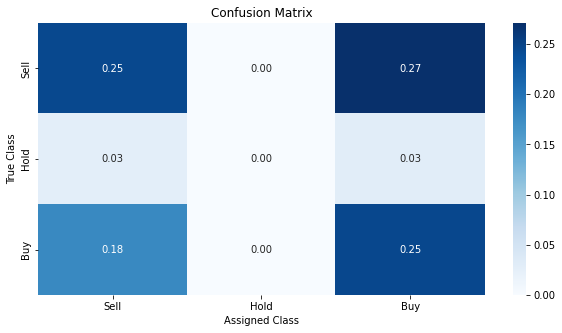

In [76]:

# n_epochs = 150
# for epoch in range(0, n_epochs):
#   ## Training the model
#   model.train()
#   train_loss = 0
#   for data, stock_class in train_loader:
#     # clear existing gradients
#     optimizer.zero_grad()
#     # Forward Propagation: Input data to get predicted classes
#     pred_classes = model(data)
#     # Batch loss
#     loss = F.cross_entropy(pred_classes, stock_class)
#     # Backpropagation: 
#     loss.backward()
#     # Update the model parameters
#     optimizer.step()
#     train_loss += loss.item()
#   model.eval()
#   val_loss = 0
#   ## Validating the model
#   # we do not want gradient descent for validation set
#   with torch.no_grad():
#     for data, stock_class in val_loader.dataset:
#       pred_classes = model(data)
#       loss = F.cross_entropy(pred_classes, stock_class)
#       val_loss += loss.item()
#   train_loss /= len(train_loader)
#   val_loss /= len(val_loader)
#   print(f"Epoch: {epoch+1}/{n_epochs}    Training loss: {train_loss}    Validation loss: {val_loss}")
  


for epoch in range(0, n_epochs):
  print("Epoch Nr: ", epoch)
  y_pred = model(X_train_nn)
  train_loss = F.cross_entropy(y_pred, y_train_nn)
  y_pred = y_pred.detach().numpy()
  #y_train_nn_np = y_train_nn.detach.numpy()
  train_f1_w = metrics.f1_score(y_train_nn, np.argmax(y_pred, axis = 1), average = "weighted")
  print("The train loss is: ", train_loss.item(), "Weighted F1 Score is: ", train_f1_w.item())
  # Backwardspropagation
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  with torch.no_grad():
    pred_classes = model(X_val_nn)
    val_loss = F.cross_entropy(pred_classes, y_val_nn)
    pred_classes = pred_classes.detach().numpy()
    val_f1_w = metrics.f1_score(y_val_nn, np.argmax(pred_classes, axis = 1), average = "weighted")
    print("The val loss is: ", val_loss.item(), "Weighted F1 Score is: ", val_f1_w.item())


with torch.no_grad():
  pred_classes = model(X_test_nn)
  test_loss = F.cross_entropy(pred_classes, y_test_nn)
  pred_classes = pred_classes.detach().numpy()
  test_f1_w = metrics.f1_score(y_test_nn, np.argmax(pred_classes, axis = 1), average = "weighted")
  print("The test loss is: ", test_loss.item(), "Weighted F1 Score is: ", test_f1_w.item())
  class_report = metrics.classification_report(y_test_nn, np.argmax(pred_classes, axis = 1))
  #print(class_report)
  cm = confusion_matrix(y_test_nn, np.argmax(pred_classes, axis = 1), normalize = "all")
  cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
  plt.figure(figsize = (10,5))
  sns.heatmap(cm, annot = True, fmt = ".2f", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")